# Projet de statistique bayésienne

**Auteurs** : Ryan Boustany, Emma Sarfati

## Résumé

Ce code est inspiré de l'article de [Rui Jin & Aixin Tan](https://arxiv.org/pdf/1903.06964v1.pdf) paru en 2020, *Fast Markov chain Monte Carlo for high dimensional Bayesian regression models with shrinkage priors*.
Bien que les auteurs aient développé un package permettant d'exécuter leur modèle sous le langage R, le code suivant n'est **nullement** inspiré du code source fourni par les auteurs. Nous n'avons pas la prétention d'avoir implémenté le modèle en Python sans aucune erreur, mais nous essayons ici de nous appuyer sur les briques théoriques de l'article (que nous rappellerons au fur et à mesure).  
Il est nécessaire d'avoir installé `tensorflow` et `tensorflow_probability` pour la dernière partie de notre travail. Les autres librairies requises sont classiques : `numpy`, `scipy`, `matplotlib`.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Résumé" data-toc-modified-id="Résumé-1">Résumé</a></span></li><li><span><a href="#Premier-algorithme-:-l'algorithme-de-Gibbs-classique" data-toc-modified-id="Premier-algorithme-:-l'algorithme-de-Gibbs-classique-2">Premier algorithme : l'algorithme de Gibbs classique</a></span><ul class="toc-item"><li><span><a href="#L'algorithme" data-toc-modified-id="L'algorithme-2.1">L'algorithme</a></span></li></ul></li><li><span><a href="#Second-algorithme-:-Fast-Markov" data-toc-modified-id="Second-algorithme-:-Fast-Markov-3">Second algorithme : Fast Markov</a></span><ul class="toc-item"><li><span><a href="#L'algorithme" data-toc-modified-id="L'algorithme-3.1">L'algorithme</a></span></li><li><span><a href="#Visualisation-de-la-convergence" data-toc-modified-id="Visualisation-de-la-convergence-3.2">Visualisation de la convergence</a></span><ul class="toc-item"><li><span><a href="#Cas-de-p&lt;n-:-convergence-de-$\sigma^2$-et-$\beta$" data-toc-modified-id="Cas-de-p<n-:-convergence-de-$\sigma^2$-et-$\beta$-3.2.1">Cas de p&lt;n : convergence de $\sigma^2$ et $\beta$</a></span></li><li><span><a href="#Cas-de-p&gt;n-:-convergence-de-$\sigma^2$" data-toc-modified-id="Cas-de-p>n-:-convergence-de-$\sigma^2$-3.2.2">Cas de p&gt;n : convergence de $\sigma^2$</a></span></li></ul></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4">Evaluation</a></span></li></ul></div>

In [1]:
import numpy as np
import math
import pandas as pd
from scipy.linalg import cho_factor, cho_solve
import numpy.polynomial.polynomial as nppol
import matplotlib.pyplot as plt
from scipy import array, linalg, dot
from scipy.stats import invgamma
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 
from scipy.stats import gamma
from scipy.stats import invgauss
from scipy.stats import t
from numpy import linalg
%matplotlib inline

In [2]:
def X_build(n,K):
    X=np.zeros([n,5*K])
    mean = np.zeros(K)
    cov = np.eye(K)
    A=np.random.multivariate_normal(mean, cov, n)
    for i in range(0,K):
        A5=nppol.polyval(A[:,i], [0,0,0,0,0,1])
        A4=nppol.polyval(A[:,i], [0,0,0,0,1,0])
        A3=nppol.polyval(A[:,i], [0,0,0,1,0,0])
        A2=nppol.polyval(A[:,i], [0,0,1,0,0,0])
        A1=nppol.polyval(A[:,i], [0,1,0,0,0,0])
        X[:,i*5]= A1
        X[:,i*5+1]= A2
        X[:,i*5+2]= A3
        X[:,i*5+3]= A4
        X[:,i*5+4]= A5
    
    return X

sigma_true = 0.11

In [3]:
def rrinvgauss(n, mu, lambd): # simulation loi inverse gaussienne
    random_vector =  np.zeros(n)
    
    if mu > 1e6 :
        random_vector = pow(np.random.multivariate_normal(1, 0, 1), -2)
    else : 
        for i in range(0 , n):
            z = np.random.normal(0,1)
            y = z*z
            x = mu+0.5*mu*mu*y/lambd - 0.5*(mu/lambd)*math.sqrt(4*mu*lambd*y+mu*mu*y*y)
            u= np.random.uniform(0,1)
            if u <= mu/(mu+x) :
                random_vector[i] = x
            else :
                random_vector[i] = mu*mu/x
    return random_vector
                

In [4]:
def reptest(x,y):
    return np.repeat(x, y, axis=0)

## Premier algorithme : l'algorithme de Gibbs classique

### L'algorithme

On rappelle l'algorithme général nommé 3BG dans le papier de [R. Tin et A.Tan](https://arxiv.org/pdf/1903.06964v1.pdf). 

For $i=1...n$ :  
- draw $\displaystyle \frac{1}{{\tau_k^2}^{[i]}}\Big\lvert\beta,{\sigma^2}^{[i-1]},Y\stackrel{ind}{\sim}\text{Inverse-Gaussian}\left(\sqrt{\frac{\lambda^2{\sigma^2}^{[i-1]}}{\lVert{\beta_{G_k}}^{[i-1]}\rVert^2}},\lambda^2\right), \, k=1...K$  
- draw $\displaystyle {\sigma^2}^{[i]}\lvert\beta,\tau^2,Y\sim\text{Inverse-Gamma}\left(\frac{n+p+2\alpha}{2},\frac{\lVert Y-X{\beta}^{[i]}\rVert_2^2+{\beta^T}^{[i]} {D_\tau^{-1}}^{[i]}{\beta}^{[i]}+2\xi}{2}\right)$  
- draw $\displaystyle \beta^{[i]}\lvert \sigma^2,\tau^2,Y\sim\mathcal{N}_p\left(\left(X^TX+{D_\tau^{-1}}^{[i]}\right)^{-1}X^TY,{\sigma^2}^{[i]}\left(X^TX+{D_\tau^{-1}}^{[i]}\right)^{-1}\right)$  

Return $(\beta^{[n]},{\sigma^2}^{[n]})$

Pour la ditribution inverse gaussienne, nous l'avons codée "à la main", dans la fonction `rrinvgauss`. Les distributions normales et inverse gamma seront appelées grâce aux fonctions `random.multivariate_normal` et `gamma` déjà codées sur Python.  
La fonction suivante `iter_bg_gibbs` nous permet d'effectuer **une étape** de l'algorithme 3BG. La fonction qui vient ensuite, `3bg`, effectue le Gibbs sampling en appelant la fonction `iter_bg_gibbs` un nombre fini de fois, qui est donné par l'argument `n_iter`. 

In [5]:
def iter_bg_gibbs(beta, sigma2, X, Y, alpha, xi, n, p, lambd, group_size):
    group_size=group_size.astype(int)
    k = len(group_size)
    beta_l2 = np.zeros(k)
    start = 0
    for i in range(0,k):
        end = start + group_size[i] - 1
        beta_i = beta[int(start):int(end)] # calcul les normes de Beta_i de chaque groupe
        beta_l2[i] = np.sum(np.square(beta_i))
        start = start + group_size[i]
        
    # Simulation de 1/tau^2 qui suit une inverse gaussienne
    # on l'appelle tau pour la lisibilité
    
    tau_inv = np.zeros(k)
    for i in range(0,k):
        mu = math.sqrt((lambd**(2)) * sigma2 / beta_l2[i]) # mu de l'inverse gaussian de 1/tau
        betai = rrinvgauss(1, mu, lambd**(2))
        #betai = invgauss.rvs(mu,lambd**(2), size=1)
        tau_inv[i] = betai
        
    # Création du vecteur tau^2 =(tau_1^2,...,tau_k^2)
    tau_inv_f = np.zeros(p)
    tau_inv_f = reptest(tau_inv, group_size)
    tau = 1 / tau_inv_f
    
    D_tau_inv = np.diag(tau_inv_f)
    
    
    # Simulation de sigma au carré (on l'appelle sigma ici):

    mean_sigma = (n+p+2*alpha)/2
    part1 = np.linalg.norm(Y - X @ beta)**2
    cov_sigma = (part1 + beta.T @ D_tau_inv @ beta + 2*xi)/2 
    sigma_new = 1/gamma.rvs(mean_sigma, loc=0, scale = 1/cov_sigma, size=1)
    #sigma_new = invgamma.rvs(mean_sigma, loc=0, scale = cov_sigma, size=1)
        
    
    # Simulation de beta :
    term = np.linalg.inv(X.T @ X + D_tau_inv)
    mean_beta =  np.dot(term , X.T @ Y)
    cov_beta =  sigma_new*term
    beta_new = np.random.multivariate_normal(mean_beta,cov_beta, 1, tol=1e-6)
    
    
    res = np.zeros(p+1)
    res[0 : p] = beta_new
    res[p] = sigma_new
    
    return res

In [6]:
def bg3(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter):
    
    n = X.shape[0]
    p = X.shape[1]
    betas = np.zeros([n_iter+1, p])
    betas[0] = beta
    sigma2s = np.zeros(n_iter+1)
    sigma2s[0] = sigma2
    for i in range(1,n_iter+1) :
        itera = iter_bg_gibbs(beta, sigma2, X, Y, alpha,xi, n, p, lambd, group_size)
        beta = itera[0:p]
        sigma2 = itera[p]
        sigma2s[i] = sigma2
        betas[i] = beta
 
    return betas,sigma2s

## Second algorithme : Fast Markov 

### L'algorithme

For $i=1...n$:  
- draw $\displaystyle \frac{1}{{\tau_k^2}^{[i]}}\Big\lvert\beta,\sigma^2,Y\stackrel{ind}{\sim}\text{Inverse-Gaussian}\left(\sqrt{\frac{\lambda^2{\sigma^2}^{[i-1]}}{\lVert{\beta_{G_K}}^{[i-1]}\rVert^2}},\lambda^2\right), \, k=1...K$
  
- draw 
    - $\displaystyle {\sigma^2}^{[i]}\lvert\beta,\tau^2,Y\sim\text{Inverse-Gamma}\left(\frac{n}{2}+\alpha,\frac{Y^T(I_n-X(X^TX+D_\tau^{-1})^{-1}X^T)Y}{2}+\xi\right)$
    - $\displaystyle \beta^{[i]}\lvert\sigma^2,\tau^2,Y\sim\mathcal{N}_p\left(\left(X^TX+{D_\tau^{-1}}^{[i]}\right)^{-1}X^TY,{\sigma^2}^{[i]}\left(X^TX+{D_\tau^{-1}}^{[i]}\right)^{-1}\right)$ 

Return $(\beta^{[n]},{\sigma^2}^{[n]})$

In [7]:
def iter_bgl_fast(beta, sigma2, X, Y, alpha, xi, n, p, lambd, group_size):
    group_size=group_size.astype(int)
    k = len(group_size)
    beta_l2_k = np.sum(np.square(beta[int(len(beta)-k):int(len(beta))]))
    
        
    # Simulation de 1/tau^2 qui suit une inverse gaussienne
    # on l'appelle tau pour la lisibilité
    
    tau_inv = np.zeros(k)
    for i in range(0,k):
        mu = math.sqrt((lambd**(2)) * sigma2 / beta_l2_k) # mu de l'inverse gaussian de 1/tau
        betai = rrinvgauss(1, mu, lambd**(2))
        #betai = invgauss.rvs(mu,lambd**(2), size=1)
        tau_inv[i] = betai
       
    
    # Création du vecteur tau^2 =(tau_1^2,...,tau_k^2)
    
    tau_inv_f = np.zeros(p)
    tau_inv_f = reptest(tau_inv, group_size)
    tau = 1 / tau_inv_f
    
    D_tau_inv = np.diag(tau_inv_f)
    
    
    # Simulation de sigma :

    mean_sigma = (n + 2*alpha)/2
    part1 = np.linalg.inv(np.dot(X.T , X)+ D_tau_inv) #(25,25)
    part2 = np.eye(n) - np.dot(X , np.dot(part1 , X.T)) #(50,50)
    part3 = np.dot(Y.T,part2) 
    part4 = np.dot(part3 , Y)
    cov_sigma = (part4)/2 + xi
    sigma_new = 1/gamma.rvs(mean_sigma, loc=0, scale = 1/cov_sigma, size=1)
    #sigma_new = invgamma.rvs(mean_sigma, loc=0, scale = cov_sigma, size=1)
        
    
    # Simulation de beta :
    
    XTY = np.dot(X.T , Y)
    mean_beta =  np.dot(part1 , XTY)
    cov_beta =  sigma_new*part1
    beta_new = np.random.multivariate_normal(mean_beta,cov_beta, 1, tol=1e-6)
    
    
    res = np.zeros(p+1)
    res[0 : p] = beta_new
    res[p] = sigma_new
    
    return res

In [8]:
def bg2(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter):
    
    n = X.shape[0]
    p = X.shape[1]
    betas = np.zeros([n_iter+1, p])
    betas[0] = beta
    sigma2s = np.zeros(n_iter+1)
    sigma2s[0] = sigma2
    for i in range(1,n_iter+1) :
        itera = iter_bgl_fast(beta, sigma2, X, Y, alpha,xi, n, p, lambd, group_size)
        beta = itera[0:p]
        sigma2 = itera[p]
        sigma2s[i] = sigma2
        betas[i] = beta
 
    return betas,sigma2s

### Visualisation de la convergence

#### Cas de p<n : convergence de $\sigma^2$ et $\beta$

In [22]:
sigma_true = 0.11

n_iter = 500

## number of examples and features 
n=1000
K=10

## models hyperparameters
lambd = 0.01
alpha = 0
xi = 0
sigma2 = 1

X=X_build(n,K) 
p=X.shape[1]   #p=5*K
beta_true=np.zeros(p)
for i in range(0,K):
    beta_true[i]=t.rvs(2, loc=0, scale=1, size=1, random_state=None)
        
Y = np.dot(X,beta_true) + np.random.normal(0, sigma_true, n)
    
n=X.shape[0]
p=X.shape[1]
beta = np.ones(p)
group_size = 5*np.ones(shape=K).astype(int)

estimationbg3=bg3(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter)
estimationbg2=bg2(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter)

print( 'True sigma :',sigma_true, 'Final sigma from the Markov chain 3BG :',math.sqrt(estimationbg3[1][100]))
print( 'True sigma :',sigma_true, 'Final sigma from the Markov chain 2BG :',math.sqrt(estimationbg2[1][100]))

True sigma : 0.11 Final sigma from the Markov chain 3BG : 0.10218606429618254
True sigma : 0.11 Final sigma from the Markov chain 2BG : 0.10147088617779142


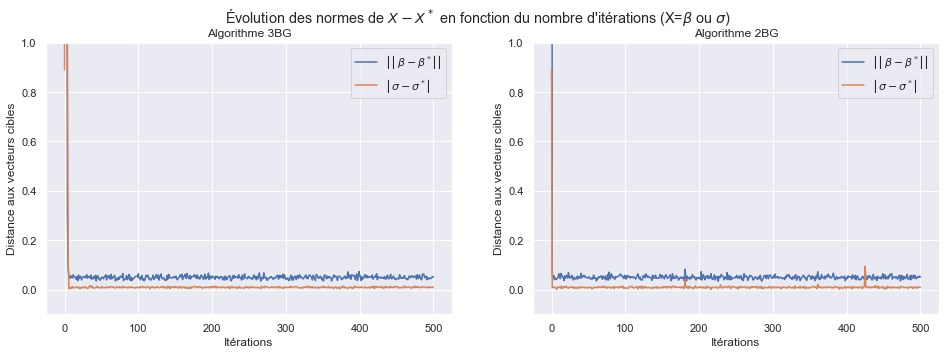

In [23]:
import seaborn as sns
sns.set(style='dark')

fig, ax = plt.subplots(1,2,figsize=(16,5))
plt.suptitle(r"Évolution des normes de $X-X^*$ en fonction du nombre d'itérations (X=$\beta$ ou $\sigma$)")

dif_beta = [estimationbg3[0][k] - beta_true for k in range(len(estimationbg3[0]))]
norms_beta = np.linalg.norm(dif_beta, axis=1)
dif_sigma = [math.sqrt(estimationbg3[1][k]) - sigma_true for k in range(len(estimationbg3[1]))]
norms_sigma = [np.linalg.norm(mat) for mat in dif_sigma]

ax[0].set_ylabel('Distance aux vecteurs cibles')
ax[0].set_xlabel('Itérations')
ax[0].plot(range(len(norms_beta)), norms_beta, label=r'$⎜⎜\beta-\beta^*⎜⎜$')
ax[0].plot(range(len(norms_sigma)), norms_sigma, label='$⎜\sigma-{\sigma}^*⎜$')
ax[0].set_title('Algorithme 3BG')
ax[0].set_ylim([-0.1,1])
ax[0].grid()
ax[0].legend()

dif_beta = [estimationbg2[0][k] - beta_true for k in range(len(estimationbg2[0]))]
norms_beta = np.linalg.norm(dif_beta, axis=1)
dif_sigma = [math.sqrt(estimationbg2[1][k]) - sigma_true for k in range(len(estimationbg2[1]))]
norms_sigma = [np.linalg.norm(mat) for mat in dif_sigma]

ax[1].set_ylabel('Distance aux vecteurs cibles')
ax[1].set_xlabel('Itérations')
ax[1].plot(range(len(norms_beta)), norms_beta, label=r'$⎜⎜\beta-\beta^*⎜⎜$')
ax[1].plot(range(len(norms_sigma)), norms_sigma, label='$⎜\sigma-{\sigma}^*⎜$')
ax[1].set_title('Algorithme 2BG')
ax[1].set_ylim([-0.1,1])
ax[1].grid()
ax[1].legend()

plt.show()

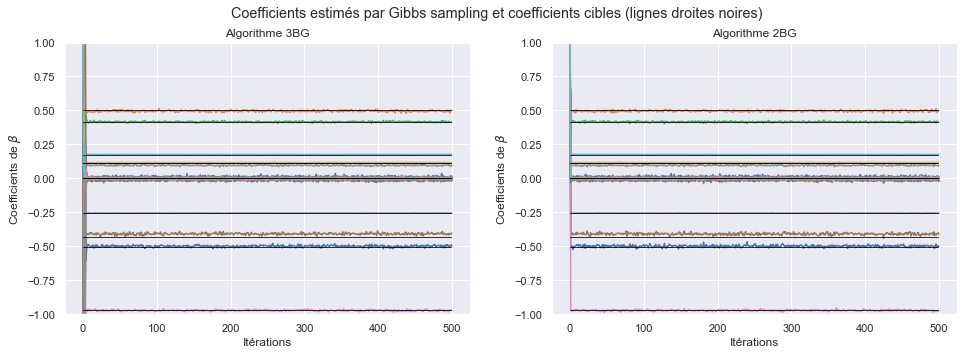

In [24]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
plt.suptitle('Coefficients estimés par Gibbs sampling et coefficients cibles (lignes droites noires)')

axis = [np.array(beta_true) for k in range(n_iter)]

ax[0].set_ylabel(r'Coefficients de $\beta$')
ax[0].set_xlabel('Itérations')
ax[0].plot(estimationbg3[0], label='$\beta$')
ax[0].plot([np.array(beta_true) for k in range(n_iter)], color='black', linewidth=0.8)
ax[0].set_title('Algorithme 3BG')
ax[0].set_ylim([-1,1])
ax[0].grid()

ax[1].set_ylabel(r'Coefficients de $\beta$')
ax[1].set_xlabel('Itérations')
ax[1].plot(estimationbg2[0], label='$\beta$')
ax[1].plot([np.array(beta_true) for k in range(n_iter)], color='black', linewidth=0.8)
ax[1].set_title('Algorithme 2BG')
ax[1].set_ylim([-1,1])
ax[1].grid()

plt.show()

#### Cas de p>n : convergence de $\sigma^2$

In [19]:
sigma_true = 0.11

n_iter = 500

## number of examples and features 
n=100
K=40

## models hyperparameters
lambd = 1
alpha = 0
xi = 0
sigma2 = 1

X=X_build(n,K) 
p=X.shape[1]   #p=5*K
beta_true=np.zeros(p)
for i in range(0,K):
    beta_true[i]=t.rvs(2, loc=0, scale=1, size=1, random_state=None)
        
Y = np.dot(X,beta_true) + np.random.normal(0, sigma_true, n)
    
n=X.shape[0]
p=X.shape[1]
beta = np.ones(p)
group_size = 5*np.ones(shape=K).astype(int)

estimationbg3=bg3(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter)
estimationbg2=bg2(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter)

print( 'True sigma :',sigma_true, 'Final sigma from the Markov chain 3BG :',math.sqrt(estimationbg3[1][n_iter]))
print( 'True sigma :',sigma_true, 'Final sigma from the Markov chain 2BG :',math.sqrt(estimationbg2[1][n_iter]))

True sigma : 0.11 Final sigma from the Markov chain 3BG : 0.1782599850548294
True sigma : 0.11 Final sigma from the Markov chain 2BG : 0.07968233341504644


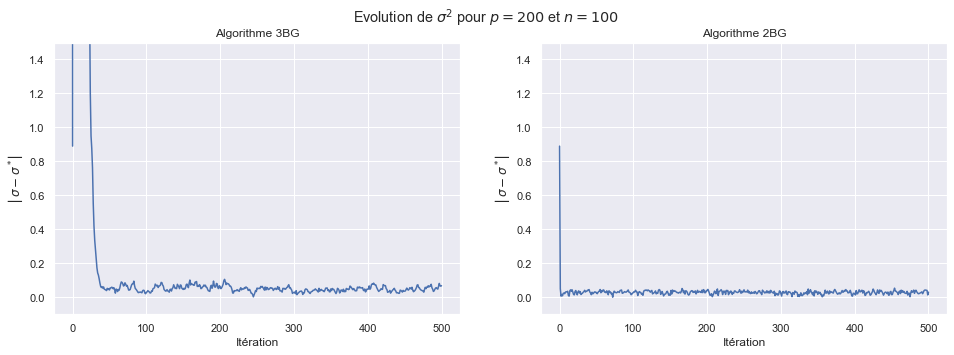

In [20]:
import seaborn as sns
sns.set(style='dark')

fig, ax = plt.subplots(1,2,figsize=(16,5))
plt.suptitle("Evolution de $\sigma^2$ pour $p=200$ et $n=100$")

dif_sigma = [math.sqrt(estimationbg3[1][k]) - sigma_true for k in range(len(estimationbg3[1]))]
norms_sigma = [abs(mat) for mat in dif_sigma]

ax[0].set_ylabel(r"$⎜\sigma-{\sigma}^*⎜$")
ax[0].set_xlabel('Itération')
ax[0].plot(range(len(norms_sigma)), norms_sigma)
ax[0].set_title('Algorithme 3BG')
ax[0].set_ylim([-0.1,1.5])
ax[0].grid()

dif_sigma = [math.sqrt(estimationbg2[1][k]) - sigma_true for k in range(len(estimationbg2[1]))]
norms_sigma = [abs(mat) for mat in dif_sigma]

ax[1].set_ylabel(r"$⎜\sigma-{\sigma}^*⎜$")
ax[1].set_xlabel('Itération')
ax[1].plot(range(len(norms_sigma)), norms_sigma)
ax[1].set_title('Algorithme 2BG')
ax[1].set_ylim([-0.1,1.5])
ax[1].grid()

plt.show()

Notons que nous avons modifié le paramètre $\lambda$ pour ce contexte.  
Les deux algorithmes nous donnent une approximation de la variance. Au bout de $100^e$ itération, l'algorithme 2BG proposé par les auteurs atteint une approximation plus satisfaisante. Notons cependant que en changeant un hyperparamètre, un Sampler peut performer mieux que l'autre. Les résultats sont globalement comparables. En regardant l'évolution de la chaîne, l'algorithme Gibbs classique semble prendre plus de temps avant de se rapprocher de la valeur cible. 2BG semble plus direct.  
Il convient de nuancer ces résultats : la convergence est sensible au paramètre que nous posons sur l'a priori du paramètre de *shrinkage* $\tau$.  
L'idée de [R. Tin et A.Tan](https://arxiv.org/pdf/1903.06964v1.pdf) est alors d'évaluer, en termes de vitesse de convergence, la chaîne de Markov alors construite par le Gibbs sampler. Nous introduisons l'effective sampling size, donnée par : 

$$N_{eff}=\frac{N}{1+2\sum_{k=1}^\infty \rho_k}$$

L'effective sampling size est une estimation du nombre de tirages requis lors de l'algorithme afin d'atteindre le même niveau de précision que si le tirage était aléatoire. Il s'agit d'une mesure importante de l'efficacité d'une méthode de Monte-Carlo comme celles présentées par les algorithmes que les auteurs ont proposé.  Cette métrique évalue la qualité du tirage effectué par les algorithmes 2BG et 3BG à chaque itération. Numériquement, plus $N_{eff}$ est élevé, plus ceci indique une meilleure mixité de la chaîne puisqu'il s'agit d'une fonction décroissante des autocorrélations. 

## Evaluation

La métrique $N_{eff}$ est implémentée en temps que fonction `effective_sample_size` dans le module `tensorflow_probability` et correspond à la formule décrite juste au-dessus (voir https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/effective_sample_size). Comme le proposent les auteurs, nous allons également prendre le temps de calcul en considération et allons examiner non pas $N_{eff}$ mais $\displaystyle \frac{N_{eff}}{T}$, l'effective sample size moyen par seconde. Autrement dit, le temps de calcul de l'effective sample size est également pris en compte afin de normaliser les valeurs de $N_{eff}$ d'un algorithme à l'autre, mais également de donner un sens à la caractérisation dite "rapide" de l'algorithme 2BG proposé par les auteurs.

On va chercher à évaluer, pour chaque valeur de $p$, l'effective sample size de la chaîne de $\sigma^2$ induite par les algorithmes 2BG et 3BG. Les autocorrélations seront également évaluées afin de calculer la mixité des chaînes. R. Jin et A. Tan indiquent qu'une faible auto-corrélation implique une bonne mixitié de la chaîne induite et donc un meilleur mélange réalisé par l'algorithme.

In [14]:
import tensorflow as tf
import tensorflow_probability as tfp

In [15]:
import timeit

autocorrs = []
effs = []
axis = []

lambd = 1
alpha = 0
xi = 0
sigma2 = 1

def metrics(n,n_iter):
    autocorrs1 = []
    effs1 = []
    autocorrs2 = []
    effs2 = []
    axis = []
    for K in [5,6,7,8,9,10,20,30,40,50]:

        X=X_build(n,K) #n=50 p=5*K
        p=X.shape[1]
        beta_true=np.zeros(p)
        for i in range(0,K):
            beta_true[i]=t.rvs(2, loc=0, scale=1, size=1, random_state=None)
        
        Y = np.dot(X,beta_true) + np.random.normal(0, sigma_true, n)
    
        ## calculus of the autocorrelations of the Markov chain and effective sample size time computation
        
        n=X.shape[0]
        p=X.shape[1]
        beta = np.ones(p)
        group_size = 5*np.ones(shape=K).astype(int)
        
        # algorithm 2BG
        start = timeit.default_timer() # computation times of the Neff of the Hidden Markov chain
        estimation = bg2(X, Y, group_size, beta, sigma2,lambd, alpha, xi, n_iter)
        eff = tfp.mcmc.effective_sample_size(estimation[1]).numpy()
        stop = timeit.default_timer()
        
        s = pd.Series(estimation[1])
        autocorrs1.append(s.autocorr())# one lag autocorrelation of the chain
        effs1.append(eff/(stop-start)) # N_eff / T

        # algorithm 3BG
        start = timeit.default_timer() # computation times of the Neff of the Hidden Markov chain
        estimation = bg3(X, Y, group_size, beta, sigma2,lambd, alpha, xi, n_iter)
        eff = tfp.mcmc.effective_sample_size(estimation[1]).numpy()
        stop = timeit.default_timer()
        
        s = pd.Series(estimation[1])
        autocorrs2.append(s.autocorr())# one lag autocorrelation of the chain
        effs2.append(eff/(stop-start)) # N_eff / T
        axis.append(p/n)
        
    return axis,autocorrs1,effs1,autocorrs2,effs2

In [16]:
n = 50
n_iter = 500
axis,autocorrs2BG,effs2BG,autocorrs3BG,effs3BG = metrics(n,n_iter)

n = 100
n_iter = 500
axis_,autocorrs2BG_,effs2BG_,autocorrs3BG_,effs3BG_ = metrics(n,n_iter)

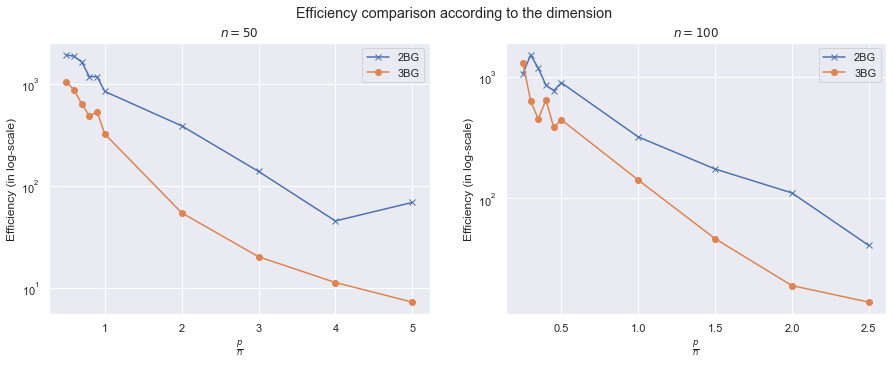

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle('Efficiency comparison according to the dimension')

ax[0].set_ylabel('Efficiency (in log-scale)')
ax[0].set_xlabel(r"$\frac{p}{n}$")
ax[0].plot(axis,effs2BG,label='2BG',marker='x')
ax[0].plot(axis,effs3BG,label='3BG',marker='o')
ax[0].legend()
ax[0].set_title('$n=50$')
ax[0].grid()
ax[0].set_yscale('log')
             
ax[1].set_ylabel('Efficiency (in log-scale)')
ax[1].set_xlabel(r"$\frac{p}{n}$")
ax[1].plot(axis_,effs2BG_,label='2BG',marker='x')
ax[1].plot(axis_,effs3BG_,label='3BG',marker='o')
ax[1].legend()
ax[1].set_title('$n=100$')
ax[1].grid()
ax[1].set_yscale('log')

Comme l'ont montré R. Jin et A. Tal, si les efficacités sont comparables pour $p<n$, l'écart se creuse lorsque $p$ devient plus grand que $n$. L'efficacité de l'algorithme 2BG est bien supérieure, sur les différents ranges $(p,n)$, pour 2BG par rapport à 3BG.  Les efficacités des algorithmes sont de plus en plus écartées pour $p$ plus grand que $n$, ce qui prouve la pertinence du nouveau modèle en particulier pour la grande dimension. Notons que les valeurs des *efficiencies* ne sont pas les mêmes, au niveau de l'échelle de $\displaystyle \frac{N_{eff}}{T}$, que dans l'article de R. Jin et A. Tan, à cause du temps de calcul $T$ qui n'est pas pareil au vu de la différence de puissance de nos machines. Les résultats restent cependant visibles car il s'agit d'une relation de proportionnalité.

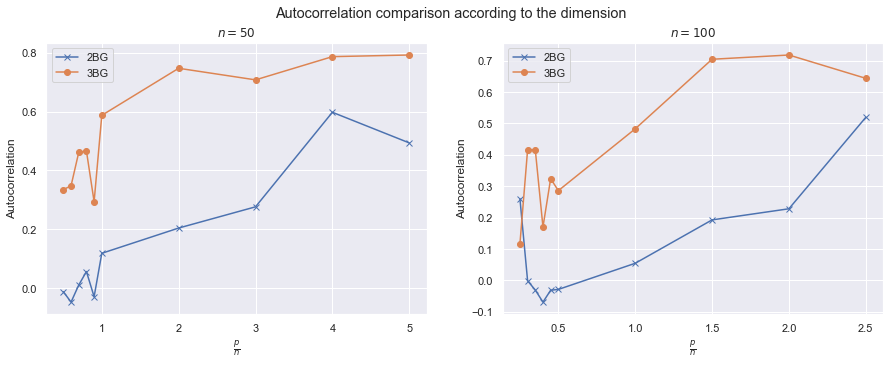

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle('Autocorrelation comparison according to the dimension')

ax[0].set_ylabel('Autocorrelation')
ax[0].set_xlabel(r"$\frac{p}{n}$")
ax[0].plot(axis,autocorrs2BG,label='2BG',marker='x')
ax[0].plot(axis,autocorrs3BG,label='3BG',marker='o')
ax[0].legend()
ax[0].set_title('$n=50$')
ax[0].grid()

             
ax[1].set_ylabel('Autocorrelation')
ax[1].set_xlabel(r"$\frac{p}{n}$")
ax[1].plot(axis_,autocorrs2BG_,label='2BG',marker='x')
ax[1].plot(axis_,autocorrs3BG_,label='3BG',marker='o')
ax[1].legend()
ax[1].set_title('$n=100$')
ax[1].grid()

plt.show()

On voit que l'algorithme 2BG présente des autocorrélations nettement inférieures à celles de la chaîne de l'algorithme 3BG, comme démontré par les auteurs dans l'article. Cet écart indique un meilleur mélange réalisé par l'algorithme 2BG.